<a href="https://colab.research.google.com/github/brunowdf/Projeto-Classifica-o/blob/main/Projeto_Animais_Classifica%C3%A7%C3%A3o_com_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Data preprocessing

In [2]:
!curl -L "https://app.roboflow.com/ds/UgxXuChaJw?key=TFxFxlYDA8" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   894  100   894    0     0   1732      0 --:--:-- --:--:-- --:--:--  1735
100 14.5M  100 14.5M    0     0  19.5M      0 --:--:-- --:--:-- --:--:--  530M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: train/
   creating: train/Cat/
   creating: train/Cat Dog/
 extracting: train/Cat Dog/Gato62_jpg.rf.94bb924102010ceb0536db36ad7bee1a.jpg  
 extracting: train/Cat Dog/Gato62_jpg.rf.c7b00ece0874d73a535f42087a4e6c7f.jpg  
 extracting: train/Cat Dog/Gato62_jpg.rf.e19164747f347c37d06bcdf0b4d88424.jpg  
 extracting: train/Cat Dog/Gato68_jpg.rf.5f6da98b631f98afc0f08b0d24ddb0d0.jpg  
 extracting: train/Cat Dog/Gato68_jpg.rf.872d850bfd753973cb1cca075379e7e6.jpg  
 extracting: train/Cat Dog/Gato68_jpg.rf.8a20271749dd19934f950f2fbde95876.jpg  
 extracting: train/Cat Dog/Gato74

We need to turn this dataset into a Tensorflow Dataset format. 

In [3]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
# raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='images/',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=330, num_shards=1>,
        'valid': <SplitInfo num_examples=40, num_shards=1>,
    },
    citation="""""",
)


Show images and labels from the training set:

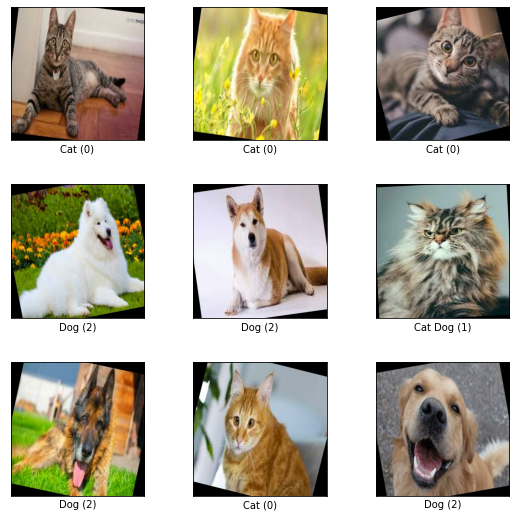

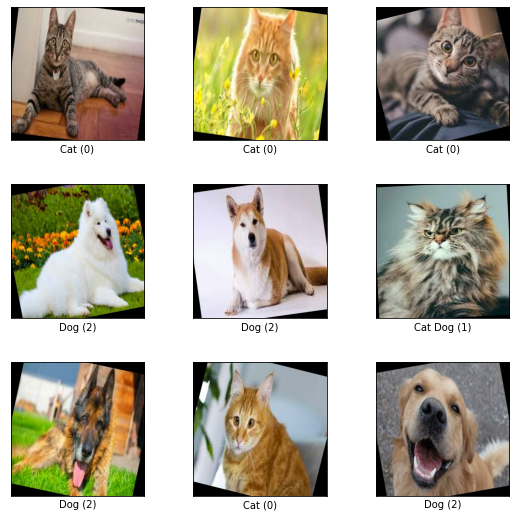

In [4]:
tfds.show_examples(raw_train, builder.info)

### Format the Data

We can use the `tf.image` module to format the images for the task.

Resize the images to a fixed input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [5]:
IMG_SIZE = 640 # All images will be resized to 160x160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset using the map method:

In [6]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)

Now shuffle and batch the data.

In [7]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

In [8]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

Inspect a batch of data:

In [9]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([64, 640, 640, 3])

## Create the base model from the pre-trained convnets


In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 20, 20, 1280)


## Feature extraction


### Freeze the convolutional base



In [12]:
base_model.trainable = False

In [13]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 320, 320, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 320, 320, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [16]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model


In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [19]:
len(model.trainable_variables)

2

### Train the model

After training for 20 epochs, you should see ~90%+ accuracy.


In [20]:
initial_epochs = 830
validation_steps=830

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

  1/830 [..............................] - ETA: 58:50 - loss: 0.5583 - accuracy: 0.4000

830/830 [==============================] - 5s 471us/step - loss: 0.5583 - accuracy: 0.4000


In [21]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.56
initial accuracy: 0.40


In [22]:
# Weights & Biases  (optional)
%pip install -q wandb
import wandb

     |████████████████████████████████| 1.9 MB 4.8 MB/s 
     |████████████████████████████████| 166 kB 62.1 MB/s 
     |████████████████████████████████| 182 kB 62.8 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 166 kB 68.3 MB/s 
     |████████████████████████████████| 162 kB 66.3 MB/s 
     |████████████████████████████████| 162 kB 66.7 MB/s 
     |████████████████████████████████| 158 kB 69.4 MB/s 
     |████████████████████████████████| 157 kB 65.1 MB/s 
     |████████████████████████████████| 157 kB 68.0 MB/s 
     |████████████████████████████████| 157 kB 70.2 MB/s 
     |████████████████████████████████| 157 kB 70.5 MB/s 
     |████████████████████████████████| 157 kB 66.1 MB/s 
     |████████████████████████████████| 157 kB 69.1 MB/s 
     |████████████████████████████████| 157 kB 67.8 MB/s 
     |████████████████████████████████| 156 kB 65.5 MB/s 


In [23]:
import sys

def wandb_colab_login():
  """Temporary hack to prevent colab from hanging"""
  sys.modules["google.colab2"] = sys.modules["google.colab"]
  del sys.modules["google.colab"]
  wandb.login()
  sys.modules["google.colab"] = sys.modules["google.colab2"]
wandb_colab_login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [24]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    callbacks=[cp_callback])

Epoch 1/830
6/6 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.4242
Epoch 1: saving model to training_1/cp.ckpt
6/6 [==============================] - 13s 977ms/step - loss: 0.5138 - accuracy: 0.4242 - val_loss: 0.3324 - val_accuracy: 0.3500
Epoch 2/830
6/6 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.2697
Epoch 2: saving model to training_1/cp.ckpt
6/6 [==============================] - 6s 811ms/step - loss: 0.4190 - accuracy: 0.2697 - val_loss: 0.2231 - val_accuracy: 0.2250
Epoch 3/830
6/6 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.1273
Epoch 3: saving model to training_1/cp.ckpt
6/6 [==============================] - 6s 806ms/step - loss: 0.3617 - accuracy: 0.1273 - val_loss: 0.1402 - val_accuracy: 0.1750
Epoch 4/830
6/6 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.0758
Epoch 4: saving model to training_1/cp.ckpt
6/6 [==============================] - 6s 818ms/step - loss: 0.3

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

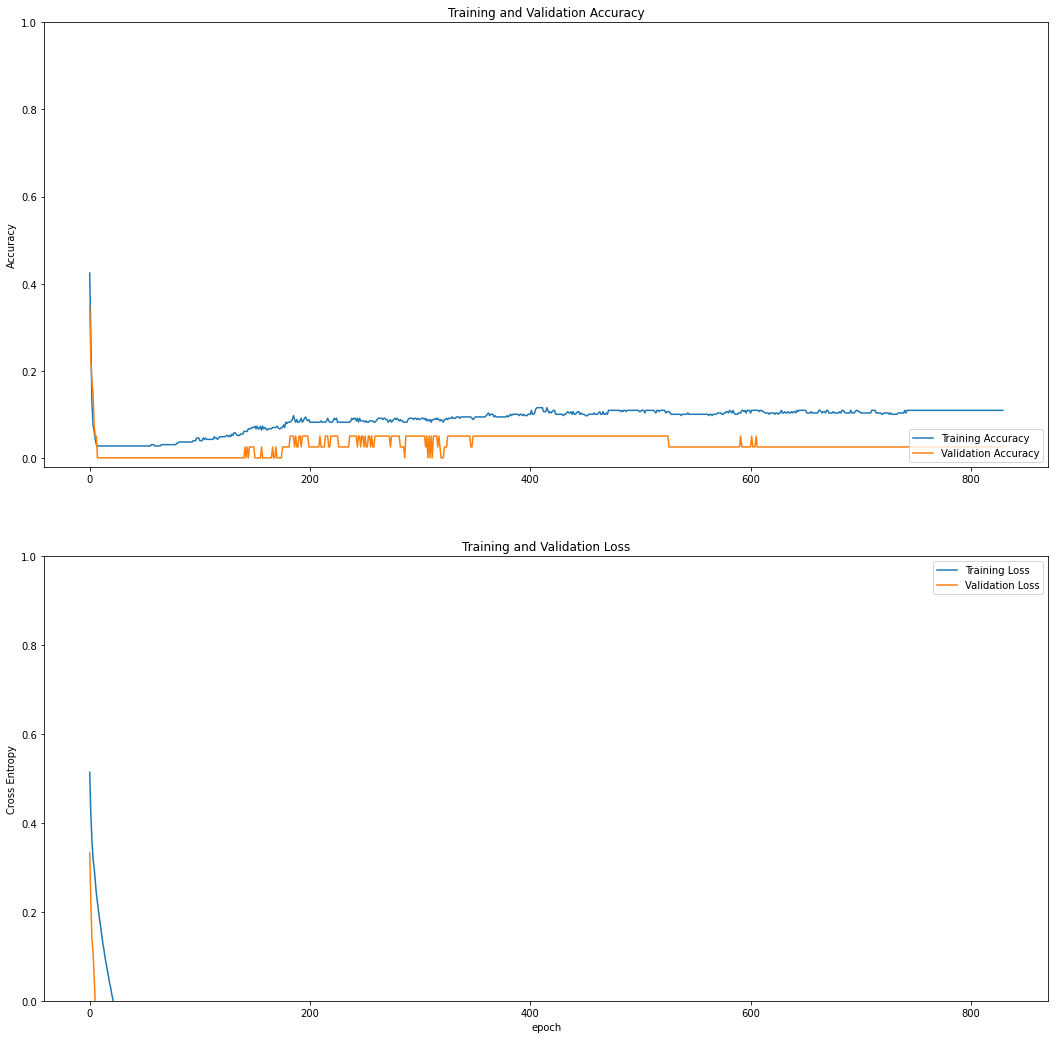

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Saving

In [26]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.9.2


In [28]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [29]:
# my_model directory
%ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
%ls saved_model/my_model

my_model/
assets/  keras_metadata.pb  saved_model.pb  variables/


In [30]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


#Saving for later

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
!mkdir /content/drive/MyDrive/BananaStepps/model

mkdir: cannot create directory ‘/content/drive/MyDrive/BananaStepps/model’: No such file or directory


In [34]:
!cp -r saved_model /content/drive/MyDrive/BananaStepps/model

cp: cannot create directory '/content/drive/MyDrive/BananaStepps/model': No such file or directory


In [35]:
!zip -r modelo.zip saved_model/my_model/ 

  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/my_model/variables/variables.index (deflated 76%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/saved_model.pb (deflated 91%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 96%)


In [36]:
!mkdir /content/drive/MyDrive/BananaStepps/model/weights

mkdir: cannot create directory ‘/content/drive/MyDrive/BananaStepps/model/weights’: No such file or directory


In [37]:
!cp -r /content/training_1 /content/drive/MyDrive/BananaStepps/model/weights

cp: cannot create directory '/content/drive/MyDrive/BananaStepps/model/weights': No such file or directory


In [38]:
!zip -r weights.zip /content/training_1

  adding: content/training_1/ (stored 0%)
  adding: content/training_1/cp.ckpt.index (deflated 78%)
  adding: content/training_1/checkpoint (deflated 38%)
  adding: content/training_1/cp.ckpt.data-00000-of-00001 (deflated 7%)


## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [48]:
base_model.trainable = True

In [49]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

Compile the model using a much lower learning rate.

In [50]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 20, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [52]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [53]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 830/930
6/6 [==============================] - 55s 1s/step - loss: -4.5370 - accuracy: 0.0273 - val_loss: -9.6913 - val_accuracy: 0.0250
Epoch 831/930
6/6 [==============================] - 7s 948ms/step - loss: -6.2148 - accuracy: 0.0364 - val_loss: -10.2074 - val_accuracy: 0.0750
Epoch 832/930
6/6 [==============================] - 7s 948ms/step - loss: -7.5983 - accuracy: 0.0364 - val_loss: -10.6844 - val_accuracy: 0.0750
Epoch 833/930
6/6 [==============================] - 8s 963ms/step - loss: -8.9869 - accuracy: 0.0545 - val_loss: -11.0472 - val_accuracy: 0.1000
Epoch 834/930
6/6 [==============================] - 7s 949ms/step - loss: -10.2088 - accuracy: 0.0636 - val_loss: -11.5675 - val_accuracy: 0.1000
Epoch 835/930
6/6 [==============================] - 7s 953ms/step - loss: -11.4911 - accuracy: 0.1000 - val_loss: -12.1573 - val_accuracy: 0.1250
Epoch 836/930
6/6 [==============================] - 7s 956ms/step - loss: -12.7351 - accuracy: 0.1333 - val_loss: -12.3085 -

After fine tuning the model reaches 51.2% accuracy.

In [54]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'higher left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


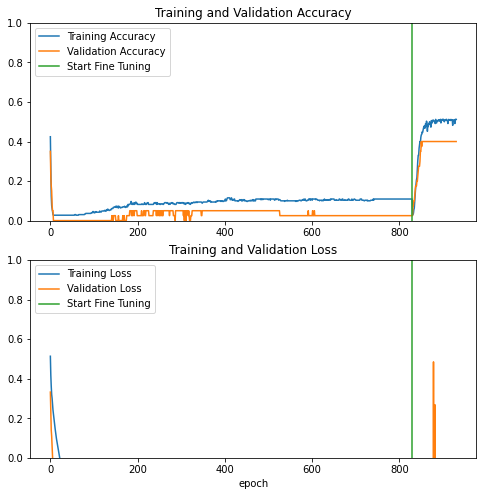

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='higher left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Infer on a Sample Image

In [ ]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
  pass
# plt.imshow(np.squeeze(image))
# plt.title("Dandelion" if model.predict(image) > 0 else "Daisy")
print(model.predict(image))

[[3.1946335]]
